Classifier Free Diffusion Model

Why: We were generating images similar to the dataset from Noise, but now is the time to control what classes to generate.

How: Create conditional diffusion model.

In [1]:
import glob
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
import torch.nn as nn

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid

# User defined libraries
from utils import *
from unet import *

In [2]:
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_CH     = 1
IMG_SIZE   = 16
BATCH_SIZE = 128
N_CLASSES = 10

In [3]:
data, dataloader = load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)

Changes to the model architecture.

We now also provide the model class context along with the time context. We also one-hot encode the classes and we use bernoulli mask to randomly mask the class. This way we are tying to help the model understand the image generates once given the class context and at the same time with no class context.

This change is implemented directly in unet.py

In [4]:
model = UNet(
    time_steps, IMG_CH, IMG_SIZE, down_chs=(64, 64, 128), t_embed_dim=8, c_embed_dim=N_CLASSES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  2002561


In [5]:
class_names = [
    "Top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [ ]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 1
preview_c = 0

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        c_drop_prob = 0.1
        optimizer.zero_grad()

        t = torch.randint(0, time_steps, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        c_hot, c_mask = get_context_mask(batch[1], c_drop_prob, N_CLASSES)
        loss = get_loss(model, x, t, c_hot, c_mask)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            class_name = class_names[preview_c]
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} | C: {class_name}")
            c_drop_prob = 0 # Do not drop context for preview
            c_hot, c_mask = get_context_mask(torch.Tensor([preview_c]), c_drop_prob, N_CLASSES)
            sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask)
            preview_c = (preview_c + 1) % N_CLASSES

Top


<Figure size 800x800 with 0 Axes>

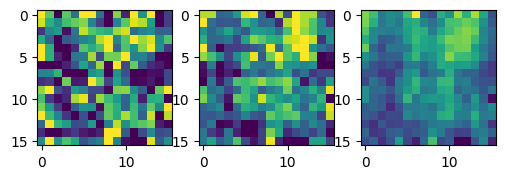

Trouser


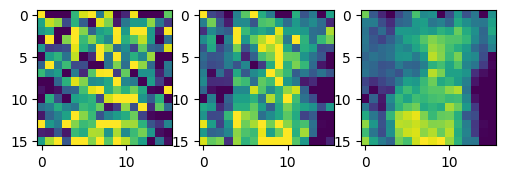

Pullover


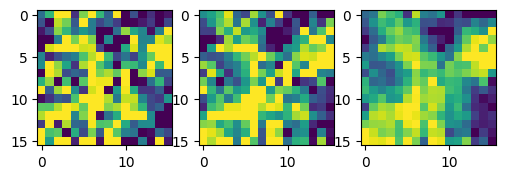

Dress


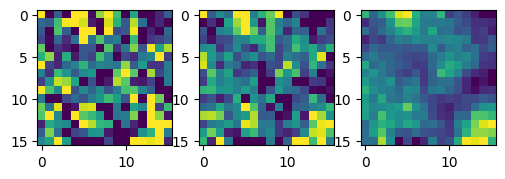

Coat


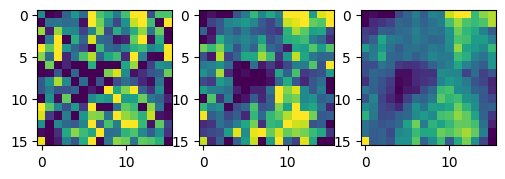

Sandal


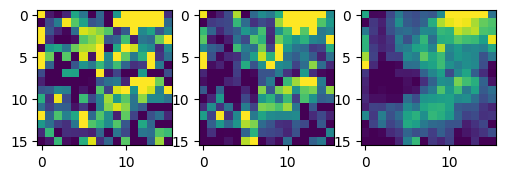

Shirt


In [ ]:
# Checking the model

plt.figure(figsize=(8,8))
ncols = 3
c_drop_prob = 0 # Change me to a value between 1 and 0

for c in range(10):
    print(class_names[c])
    c_hot, c_mask = get_context_mask(torch.Tensor([c]), c_drop_prob, N_CLASSES)
    sample_images(model, IMG_CH, IMG_SIZE, ncols, c_hot, c_mask, axis_on=True)